


参照データ(raw): (960, 52), テストデータ(raw): (960, 52)
参照データ(std): (960, 52), テストデータ(std): (960, 52)
Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 1.0126 - val_loss: 1.1652
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9873 - val_loss: 1.1620
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.9760 - val_loss: 1.1607
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.9676 - val_loss: 1.1592
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.9590 - val_loss: 1.1563
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.9494 - val_loss: 1.1522
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.9381 - val_loss: 1.1465
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.9247 - val_loss: 1.1389
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.9084 - val_loss: 1.1288
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.8891 - val_loss: 1.1153
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8667 - val_lo

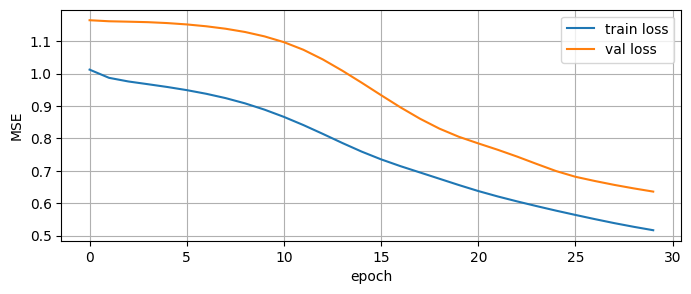

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDriftOnline

# --- AutoEncoder (TensorFlow/Keras) ---
import tensorflow as tf

# ============================================================
# 設定（ここだけ変えればOK）
# ============================================================
NORMAL_CSV  = r"..\sampleData\csv_TEPdata\tuning-data.csv"
ANOMALY_CSV = r"..\sampleData\csv_TEPdata\idv_str14_data.csv"   # 例: idv_str1_data.csv などに切替

TIME_COL  = None   # "None" ではなく None
LABEL_COL = None

FEATURE_COLS = None          # Noneなら数値列から自動
SENSOR_COLS  = None          # Noneなら FEATURE_COLS を使う（例: ["s1","s2"] に固定も可）

# ---- AE（次元削減） ----
AE_LATENT_DIM = 16           # 次元削減後の次元数（例: 8, 16, 32）
AE_HIDDEN = [128, 64]        # エンコーダの中間層（デコーダは逆順）
AE_EPOCHS = 30
AE_BATCH_SIZE = 512
AE_VAL_SPLIT = 0.1
AE_PATIENCE = 5              # EarlyStopping の patience
AE_LR = 1e-3
RANDOM_SEED = 0

# ============================================================
# 0) 入力
# ============================================================
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

df_normal = pd.read_csv(NORMAL_CSV)
df_anom   = pd.read_csv(ANOMALY_CSV)

# ============================================================
# 1) 特徴量列
# ============================================================
if FEATURE_COLS is None:
    cols = df_normal.select_dtypes(include=[np.number]).columns.tolist()
    if TIME_COL is not None and TIME_COL in cols: cols.remove(TIME_COL)
    if LABEL_COL is not None and LABEL_COL in cols: cols.remove(LABEL_COL)
    FEATURE_COLS = cols

if SENSOR_COLS is None:
    SENSOR_COLS = FEATURE_COLS

missing = [c for c in SENSOR_COLS if c not in df_anom.columns]
if missing:
    raise ValueError(f"ANOMALY_CSV に列がありません: {missing}")

X_ref_all = df_normal[SENSOR_COLS].to_numpy(np.float32)
X_test    = df_anom[SENSOR_COLS].to_numpy(np.float32)

# ============================================================
# 2) 参照を範囲で切り出し → 標準化（参照でfit）
#    ※ MMDDriftOnline には「生データ」を入れて、preprocess_fn 内で
#       scaler + encoder を適用する（パイプライン形式）
# ============================================================
X_ref   = X_ref_all  # 必要ならここで範囲切り出し

scaler     = StandardScaler()
X_ref_std  = scaler.fit_transform(X_ref).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

print(f"参照データ(raw): {X_ref.shape}, テストデータ(raw): {X_test.shape}")
print(f"参照データ(std): {X_ref_std.shape}, テストデータ(std): {X_test_std.shape}")

# ============================================================
# 3) AE を参照データ（標準化後）で学習 → encoder を作る
# ============================================================
D = X_ref_std.shape[1]

def build_ae(input_dim: int, hidden, latent_dim: int, lr: float):
    inp = tf.keras.Input(shape=(input_dim,), dtype=tf.float32)
    x = inp
    for h in hidden:
        x = tf.keras.layers.Dense(h, activation="relu")(x)
    z = tf.keras.layers.Dense(latent_dim, activation=None, name="latent")(x)
    x = z
    for h in list(hidden)[::-1]:
        x = tf.keras.layers.Dense(h, activation="relu")(x)
    out = tf.keras.layers.Dense(input_dim, activation=None)(x)

    ae = tf.keras.Model(inp, out, name="autoencoder")
    encoder = tf.keras.Model(inp, z, name="encoder")

    ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return ae, encoder

ae, encoder = build_ae(D, AE_HIDDEN, AE_LATENT_DIM, AE_LR)

cb = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=AE_PATIENCE, restore_best_weights=True
    )
]

hist = ae.fit(
    X_ref_std, X_ref_std,
    validation_split=AE_VAL_SPLIT,
    epochs=AE_EPOCHS,
    batch_size=AE_BATCH_SIZE,
    shuffle=True,
    callbacks=cb,
    verbose=1
)

# 学習状況（参考）
plt.figure(figsize=(8, 3))
plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 4) MMDDriftOnline 用の preprocess_fn（パイプライン）
#    生データ x -> scaler -> encoder -> 潜在表現 z を返す
# ============================================================
def preprocess_fn(x):
    x = np.asarray(x, dtype=np.float32)
    is_vector = (x.ndim == 1)
    if is_vector:
        x = x.reshape(1, -1)

    xz = scaler.transform(x).astype(np.float32)
    z  = encoder(xz, training=False).numpy().astype(np.float32)

    return z[0] if is_vector else z

In [3]:
# ============================================================
# 5) Online MMD の初期化（閾値の校正を含む）
#    ※ x_ref は「生データ」, preprocess_fn で AE 潜在表現へ変換してから MMD を計算
# ============================================================
window_size  = 20
ert          = 100.0
n_bootstraps = 2000
backend      = "tensorflow"  # "pytorch" でも可（このノートは TF AE）

# ---- 重要：参照データの長さチェック ----
# Online MMD は、参照データから window_size の窓を作ってブートストラップします。
# 少なくとも (window_size + ceil(ert) - 1) 点は欲しいです。
n_ref = X_ref.shape[0]
need = int(window_size + np.ceil(ert) - 1)
if n_ref < need:
    raise ValueError(
        f"参照データが短すぎます: n_ref={n_ref}, window_size={window_size}, ert={ert} -> 必要目安 >= {need}。"
        "（対処：参照を長くする / window_sizeを小さくする / ertを小さくする）"
    )

cd = MMDDriftOnline(
    x_ref=X_ref,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    preprocess_fn=preprocess_fn,
    verbose=True
)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 20/20 [01:13<00:00,  3.70s/it]


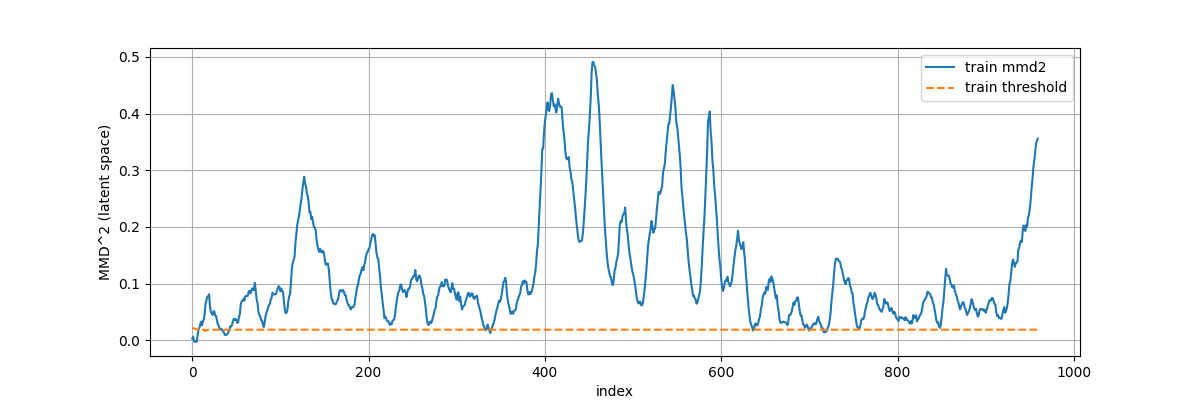

In [4]:
%matplotlib widget

# ============================================================
# 6) 正常(df_normal) を流してスコア算出＋可視化
#    ※ cd は preprocess_fn を持つので、ここでは「生データ」を流す
# ============================================================
FIGSIZE = (12, 4)
YLIM    = None  # 例: (0, 5.0)

n_tr = X_ref.shape[0]
mmd2_tr = np.full(n_tr, np.nan, float)
thr_tr  = np.full(n_tr, np.nan, float)
dr_tr   = np.zeros(n_tr, int)

for i in range(n_tr):
    out = cd.predict(X_ref[i], return_test_stat=True)
    d = out["data"]
    mmd2_tr[i] = float(d.get("test_stat", np.nan))
    thr_tr[i]  = float(d.get("threshold", np.nan))
    dr_tr[i]   = int(d.get("is_drift", 0))

t_tr = df_normal[TIME_COL].to_numpy() if (TIME_COL and TIME_COL in df_normal.columns) else np.arange(n_tr)

df_log_train = pd.DataFrame({
    "i": np.arange(n_tr),
    "t": t_tr,
    "mmd2": mmd2_tr,
    "threshold": thr_tr,
    "is_drift": dr_tr
})

plt.figure(figsize=FIGSIZE)
plt.plot(df_log_train["t"], df_log_train["mmd2"], label="train mmd2")
plt.plot(df_log_train["t"], df_log_train["threshold"], "--", label="train threshold")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_normal.columns) else "index")
plt.ylabel("MMD^2 (latent space)")
plt.ylim(YLIM)
plt.grid(True)
plt.legend()
plt.show()

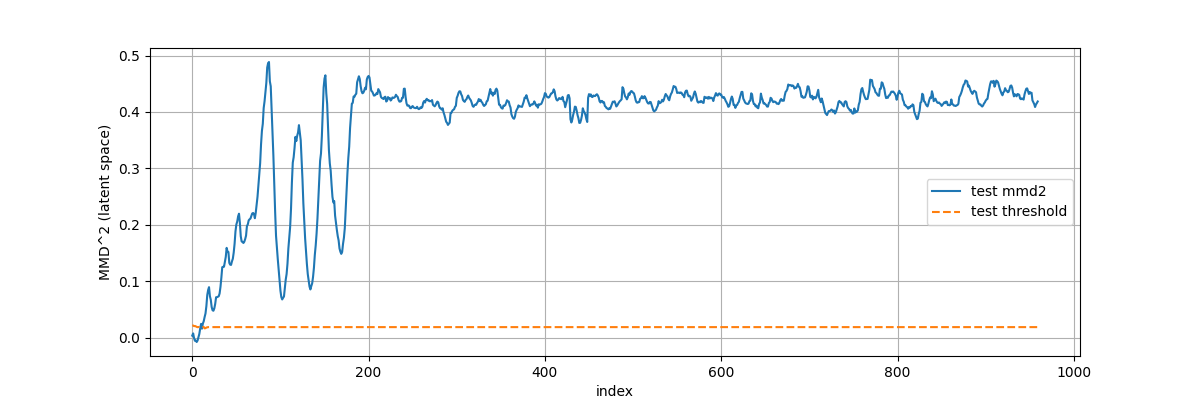

In [5]:
# ============================================================
# 7) train の後に test を流すなら必須（状態を初期化）
# ============================================================
cd.reset_state()

# ============================================================
# 8) テスト(df_anom) を流してスコア算出＋可視化
#    ※ cd は preprocess_fn を持つので、ここでは「生データ」を流す
# ============================================================
FIGSIZE = (12, 4)
YLIM    = None  # 例: (0, 5.0)

n_te = X_test.shape[0]
mmd2_te = np.full(n_te, np.nan, float)
thr_te  = np.full(n_te, np.nan, float)
dr_te   = np.zeros(n_te, int)

for i in range(n_te):
    out = cd.predict(X_test[i], return_test_stat=True)
    d = out["data"]
    mmd2_te[i] = float(d.get("test_stat", np.nan))
    thr_te[i]  = float(d.get("threshold", np.nan))
    dr_te[i]   = int(d.get("is_drift", 0))

t_te = df_anom[TIME_COL].to_numpy() if (TIME_COL and TIME_COL in df_anom.columns) else np.arange(n_te)

df_log_test = pd.DataFrame({
    "i": np.arange(n_te),
    "t": t_te,
    "mmd2": mmd2_te,
    "threshold": thr_te,
    "is_drift": dr_te
})

plt.figure(figsize=FIGSIZE)
plt.plot(df_log_test["t"], df_log_test["mmd2"], label="test mmd2")
plt.plot(df_log_test["t"], df_log_test["threshold"], "--", label="test threshold")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_anom.columns) else "index")
plt.ylabel("MMD^2 (latent space)")
plt.ylim(YLIM)
plt.grid(True)
plt.legend()
plt.show()